In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/kavehshahhosseini/tps-oct-2021-pca-and-kmeans-feature-eng/notebook?scriptVersionId=76474001

ver3

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
cont_features =[]
disc_features =[]

for col in features:
    if train[col].dtype=='float64':
        cont_features.append(col)
    else:
        disc_features.append(col)
        
features = disc_features + cont_features

In [8]:
train[cont_features] = train[cont_features].astype('float32')
train[disc_features] = train[disc_features].astype('uint8')
train[target] = train[target].astype('uint8')

test[cont_features] = test[cont_features].astype('float32')
test[disc_features] = test[disc_features].astype('uint8')

In [9]:
del cont_features
del disc_features

gc.collect()

20

# KMeans

In [10]:
n_clusters=6
kmeans = KMeans(n_clusters=n_clusters, n_init= 20, random_state=SEED)
train["cluster"] = kmeans.fit_predict(train[features])

train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f277,f278,f279,f280,f281,f282,f283,f284,target,cluster
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,1,0,0,0,0,0,0,0,1,3
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,1,0,0,0,0,0,0,0,1,5
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,0,1,1,0,0,0,0,1,1
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,0,0,1,0,0,0,0,1,0
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,1,1,0,1,0,0,1,0,1,2


In [11]:
test["cluster"] = kmeans.predict(test[features])

features += ["cluster"]

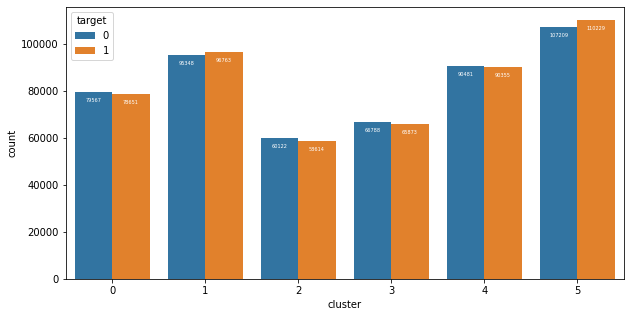

In [12]:
fig = plt.figure(figsize = (10,5))
ax = sns.countplot(data=train, x='cluster', hue="target")
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=5)
plt.show()

In [13]:
ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(np.array(train["cluster"]).reshape(-1,1)).toarray()
T_ohe = ohe.transform(np.array(test["cluster"]).reshape(-1,1)).toarray()

ohe_cols = [f"cluster{i+1}" for i in range(n_clusters)]

X_ohe = pd.DataFrame(X_ohe, columns=ohe_cols, index=train.index)
T_ohe = pd.DataFrame(T_ohe, columns=ohe_cols, index=test.index)

train = pd.concat([train, X_ohe],axis=1)
test = pd.concat([test, T_ohe],axis=1)

train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f283,f284,target,cluster,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0,0,1,3,0.0,0.0,0.0,1.0,0.0,0.0
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0,0,1,5,0.0,0.0,0.0,0.0,0.0,1.0
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,0,1,1,0.0,1.0,0.0,0.0,0.0,0.0
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,1,0,1,2,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
features.pop(-1)
features += ohe_cols 

train.drop("cluster", axis=1, inplace=True)
test.drop("cluster", axis=1, inplace=True)

# PCA

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train[features])
T_pca = pca.transform(test[features])

pca_cols = ["PC1","PC2"]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f284,target,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,PC1,PC2
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0,1,0.0,0.0,0.0,1.0,0.0,0.0,-0.142818,-0.590359
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.092288,-0.171696
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.331140,1.049479
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,1,1.0,0.0,0.0,0.0,0.0,0.0,-0.848571,0.277905
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0,1,0.0,0.0,1.0,0.0,0.0,0.0,-0.619083,0.351868


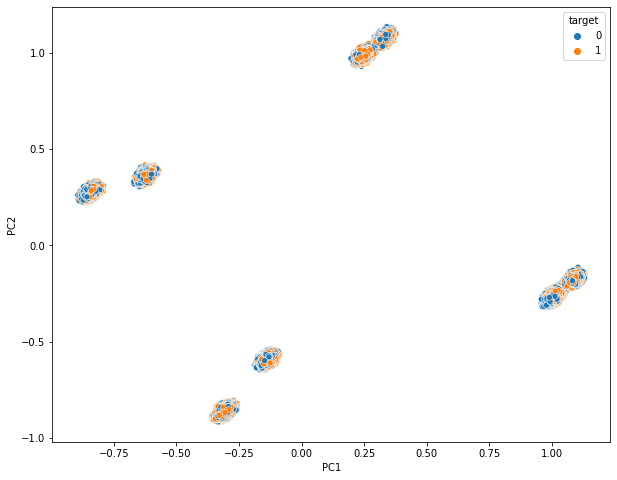

In [16]:
fig = plt.figure(figsize = (10,8))
sns.scatterplot(data=train, x="PC1", y="PC2", hue="target")
plt.show()

In [17]:
# I do remove k-means cluster columns to feature columns, since the results was not so good and it couldn't to separate them well. 
# You can tune it in order to get better results
# Note that I included cluster columns in PCA processing. So I got a different PCA results. You can test PCA without cluster columns. 
for _ in range(n_clusters):
    features.pop(-1)

features += pca_cols

print(len(features))

287


In [18]:
del n_clusters
del kmeans
del fig
del ax
del ohe
del X_ohe
del T_ohe
del ohe_cols
del pca
del X_pca
del T_pca
del pca_cols

gc.collect()

3529

In [19]:
test[features]

,f22,f43,f242,f243,f244,f245,f246,f247,f248,f249,...,f234,f235,f236,f237,f238,f239,f240,f241,PC1,PC2
0,0,1,0,0,1,0,1,1,0,0,...,0.092359,0.152883,0.266000,0.006716,0.196959,0.022934,0.199017,0.150822,0.323270,1.075940
1,1,0,0,0,0,1,1,1,0,0,...,0.126690,0.128326,0.182899,0.003132,0.190789,0.195818,0.136427,0.200248,0.338574,1.062337
2,0,0,0,1,1,1,1,1,0,1,...,0.276899,0.194539,0.283591,0.005843,0.123439,0.199566,0.217159,0.229726,-0.144531,-0.586814
3,0,0,0,0,0,0,1,1,0,1,...,0.268194,0.263770,0.487931,0.008247,0.140777,0.042808,0.196403,0.166039,0.269988,1.011533
4,1,0,0,1,0,1,1,0,0,0,...,0.191478,0.126863,0.168593,0.319238,0.155194,0.205401,0.196158,0.327414,-0.135397,-0.591547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,0,1,0,0,0,0,0,1,0,...,0.091413,0.162236,0.309894,0.011023,0.142858,0.521894,0.222184,0.251195,-0.128187,-0.583004
499996,0,0,0,0,1,1,0,1,0,0,...,0.748071,0.194264,0.207866,0.006372,0.175386,0.198387,0.142845,0.214146,0.315018,1.078848
499997,1,0,0,0,0,1,1,1,0,1,...,0.184333,0.136267,0.164835,0.006861,0.141225,0.044007,0.141896,0.228734,-0.846079,0.279887
499998,0,0,0,0,0,0,1,1,0,0,...,0.039359,0.189006,0.239799,0.005881,0.192076,0.199732,0.169161,0.271750,1.006409,-0.265123


In [20]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: uint8

# XGB

In [21]:
xgb_params = {
     'objective': 'binary:logistic',
     'n_estimators':N_ESTIMATORS,
     'importance_type': 'total_gain',
     #'booster': 'gbtree',
     'n_jobs' : -1,
     'tree_method': 'hist',
        
    'learning_rate': 0.01063045229441343, 
    'gamma': 0.24652519525750877, 
    'max_depth': 4, 
    'min_child_weight': 366, 
    'subsample': 0.6423040816299684, 
    'colsample_bytree': 0.7751264493218339, 
    'colsample_bylevel': 0.8675692743597421, 
    'use_label_encoder': False,
    'reg_lambda': 0, 
    'reg_alpha': 10
}

In [22]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+4]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold in [4]:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            xgb_params['random_state'] = inseed

            pre_model = xgb.XGBClassifier(**xgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                #early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            xgb_params2 = xgb_params.copy()
            xgb_params2['reg_lambda'] *= 0.9
            xgb_params2['reg_alpha'] *= 0.9
            xgb_params2['learning_rate'] *= 0.1
            model = xgb.XGBClassifier(**xgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='auc',
                    #early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    xgb_model=pre_model
            )    

            with open(f"xgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            xgb_importances = xgb_importances.append(fi_tmp)

            xgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            xgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, xgb_oof[val_idx])
        print(f"fold {fold} - xgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

xgb_pred /= N_SPLITS
print(f"oof xgb_auc = {roc_auc_score(train[target], xgb_oof)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)

===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
===== fold 4 =====
[0]	validation_0-auc:0.81559
[1000]	validation_0-auc:0.84662
[2000]	validation_0-auc:0.85195
[3000]	validation_0-auc:0.85411
[4000]	validation_0-auc:0.85518
[5000]	validation_0-auc:0.85573
[6000]	validation_0-auc:0.85604
[7000]	validation_0-auc:0.85620
[8000]	validation_0-auc:0.85628
[9000]	validation_0-auc:0.85630
[9999]	validation_0-auc:0.85628
[0]	validation_0-auc:0.85628
[1000]	validation_0-auc:0.85627
[2000]	validation_0-auc:0.85627
[3000]	validation_0-auc:0.85627
[4000]	validation_0-auc:0.85628
[5000]	validation_0-auc:0.85627
[6000]	validation_0-auc:0.85627
[7000]	validation_0-auc:0.85627
[8000]	validation_0-auc:0.85627
[9000]	validation_0-auc:0.85627
[9999]	validation_0-auc:0.85626
fold 4 - xgb auc: 0.856317, elapsed time: 11814.99sec

oof xgb_auc = 0.5142526839763503


# OOF predictions

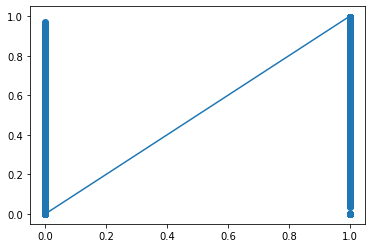

In [23]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

In [24]:
del train
del xgb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'XGB feature importances')

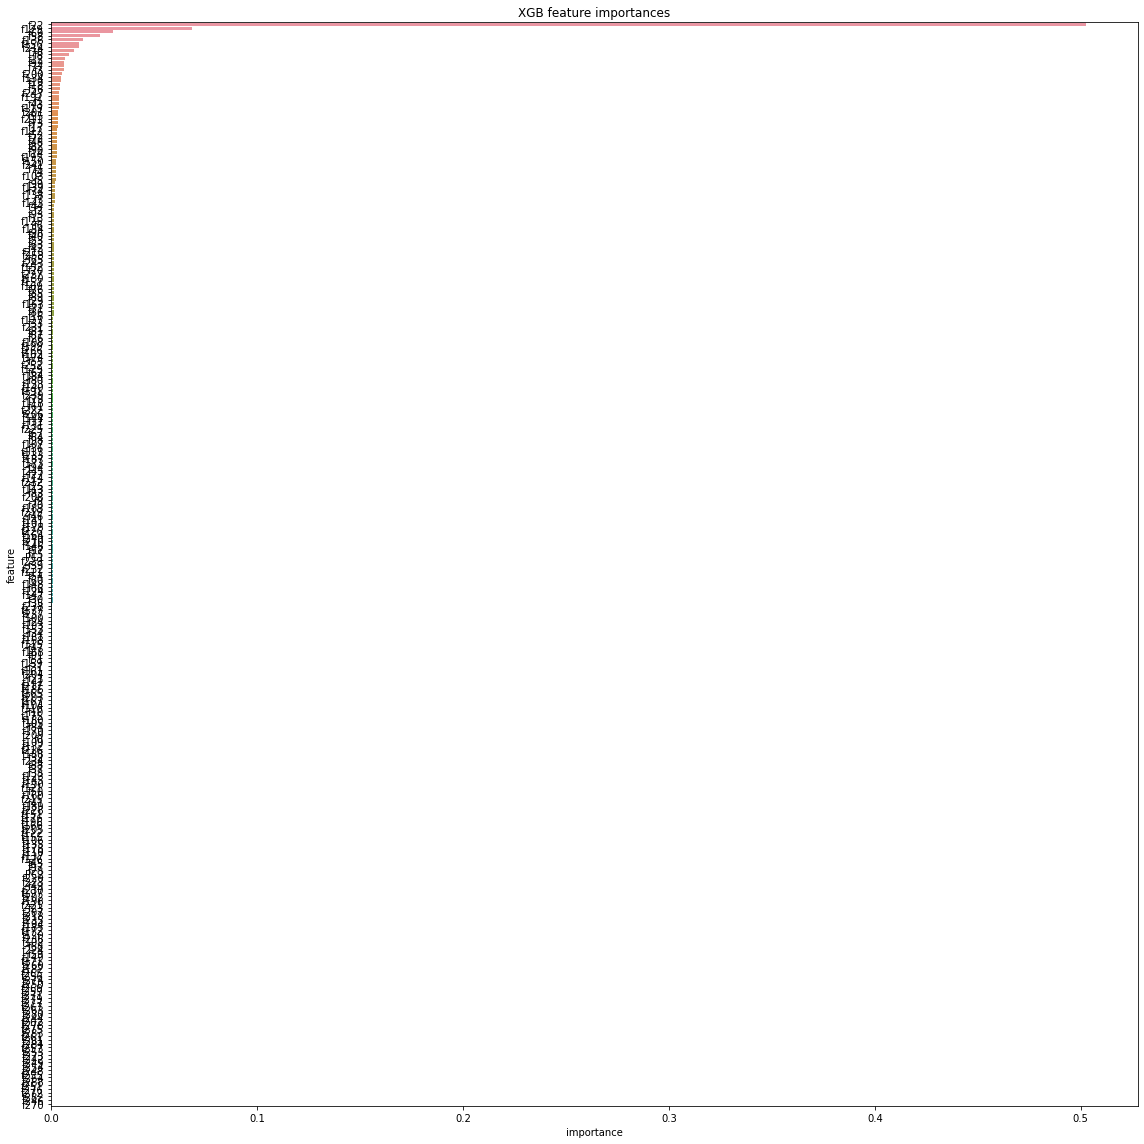

In [25]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("XGB feature importances")

# Submission

In [26]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.143230
1,1000001,0.049918
2,1000002,0.180909
3,1000003,0.171724
4,1000004,0.055946
...,...,...
499995,1499995,0.194154
499996,1499996,0.165872
499997,1499997,0.057768
499998,1499998,0.097038


# Log

seeds

2017 ver2 fold 0-1 ver3 fold 2-3 ver4 fold 4
2018 ver5 fold 0-1 ver6 fold 2-3 ver7 fold 4
2019 ver8 fold 0-1 ver9 fold 2-3 ver10 fold 4
2020 ver14 fold 0-1 ver15 fold 2-3 ver16 fold 4
2021 ver17 fold 0-1 ver18 fold 2-3 ver19 fold 4
